This notebook generates several synthetic wind time series meant to replicate the real wind data and then runs the wind profile analysis.

In [2]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from local_utils import *
import matplotlib.dates as md

which_sol = "0133"
path = './MEDA_WS_Data/'
WS_file = path + 'WE__%s___________DER_WS__________________P02.xml' % (which_sol)

time, wind = retrieve_time_wind(WS_file)
wind *= 100. # cm/s
correct_zstar = 2. # cm
correct_ustar = kappa*np.mean(wind)/np.log(zs[0]/correct_zstar)
print(correct_ustar)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing label: ./MEDA_WS_Data/WE__0133___________DER_WS__________________P02.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
30.725532319628844


1.0763549084974238 4.365874798298158e+37


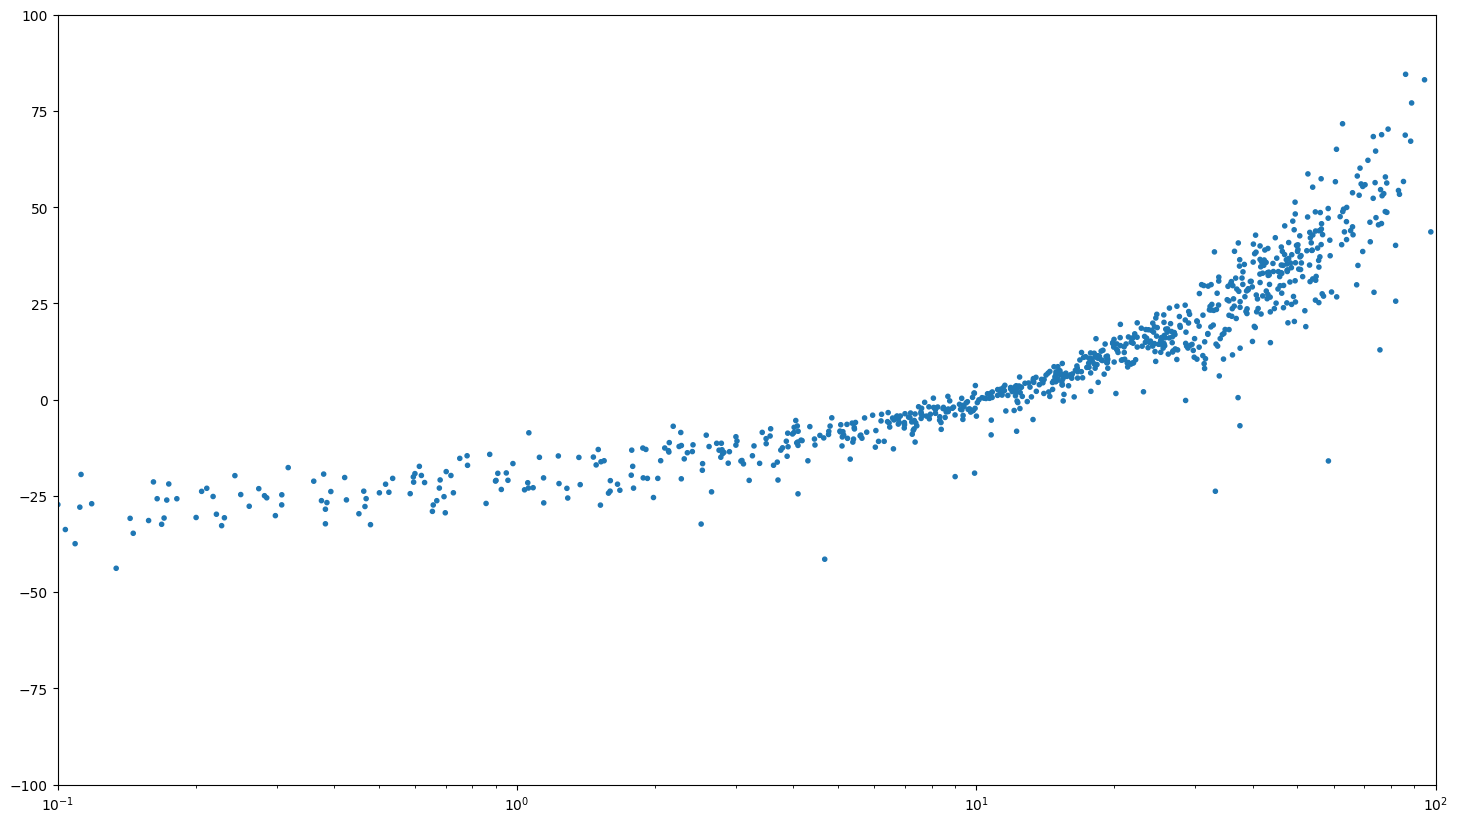

In [9]:
num_time_series = 1000
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

correct_ustars = np.array([])
saved_ustars = np.array([])
saved_zstars = np.array([])
saved_sigma_ustars = np.array([])
saved_sigma_zstars = np.array([])

t0 = np.min(time)
ind = retrieve_relevant_times(time, t0, len(zs)*sample_time)

for i in range(num_time_series):
    synthetic_wind = generate_synthetic_wind(time, wind)
    
    scaled_windspeeds = create_synthetic_wind_profile(synthetic_wind, zs, correct_zstar, z0=np.min(zs))    
    averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, scaled_windspeeds, zs)
    
    ustar, zstar, sigma_ustar, sigma_zstar, std_windspeeds =\
        fit_wind_profile_scaled_values(zs, averaged_windspeeds, std_windspeeds, rescale_unc=True)

    # Collect ustar and zstar and uncertainties - Check that the fit worked
#     if((zstar > 100) | (ustar < 0)):
#         continue
    
    correct_ustars = np.append(correct_ustars, kappa*averaged_windspeeds[0]/np.log(zs[0]/correct_zstar))

    saved_ustars = np.append(saved_ustars, ustar)
    saved_zstars = np.append(saved_zstars, zstar)
    saved_sigma_ustars = np.append(saved_sigma_ustars, sigma_ustar)
    saved_sigma_zstars = np.append(saved_sigma_zstars, sigma_zstar)

# ax.errorbar(saved_zstars, saved_ustars - correct_ustars, 
#             xerr=saved_sigma_zstars, yerr=saved_sigma_ustars, ls='', marker='o')
ax.scatter(saved_zstars, saved_ustars - correct_ustars, ls='', marker='.')
ax.set_xscale('log')
ax.set_xlim([1e-1, 100])
ax.set_ylim([-100, 100])

print(np.nanmean(saved_ustars - correct_ustars), np.nanmean(saved_zstars - correct_zstar))

-45.42764545848396


(-0.3010299956639812, 0.3010299956639812)

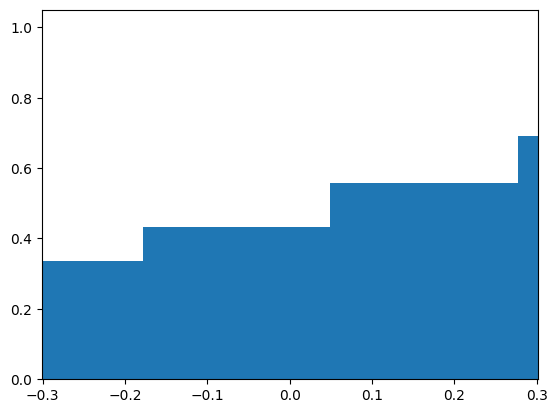

In [23]:
# fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)

ind = (np.isfinite(saved_sigma_zstars)) & (np.isfinite(saved_zstars)) & (saved_zstars > 0.)
print(np.nanmin(np.log10(saved_zstars[ind]/correct_zstar)))
plt.hist(np.log10(saved_zstars[ind]/correct_zstar), bins='auto', cumulative=True, density=True);
plt.xlim([np.log10(0.5), np.log10(2.)])
# plt.axvline(np.log10(0.5))
# plt.axvline(np.log10(2.))

1000


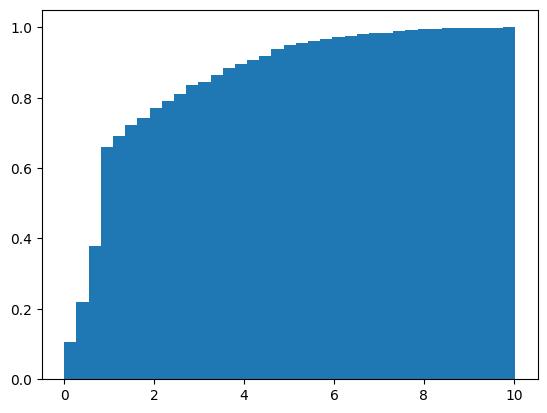

In [9]:
# fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)
print(len(saved_zstars))
ind = (np.isfinite(saved_sigma_zstars)) & (np.isfinite(saved_zstars)) & (saved_zstars < 1000)
plt.hist(np.abs(saved_zstars[ind] - correct_zstar)/correct_zstar, 
         bins='auto', cumulative=True, density=True);